In [1]:
LOG_PATH = "Logs/12Mar2025"

import os, fnmatch
def find_uwb_scanner_logs(directory):
    matching_files = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if fnmatch.fnmatch(filename, '*-uwb-scanner-log.json'):
                matching_files.append(os.path.join(root, filename))
    
    return matching_files

scans = []
import json
for file_path in find_uwb_scanner_logs(LOG_PATH):
    with open(file_path, 'r') as json_file:
            scan = json.load(json_file)
    scans.append(scan)

In [2]:
scan = scans[0]
scan[17:20]

[{'timestamp': 1741771114.0298629,
  'label': 'Beacon Location Update',
  'content': {'beaconName': 'DWM3001CDK (8449B511)',
   'position': [0.32563356, -0.5829439, -1.0706218]}},
 {'content': {'beaconName': 'DWM3001CDK (8449B511)',
   'position': [0.32563356, -0.5829439, -1.0706218]},
  'timestamp': 1741771114.058295,
  'label': 'Beacon Location Update'},
 {'content': {'beaconName': 'DWM3001CDK (8449B511)',
   'position': [0.32563356, -0.5829439, -1.0706218]},
  'timestamp': 1741771114.059287,
  'label': 'Beacon Location Update'}]

In [3]:
scan_filtered = list(filter(lambda x: x['label'] == 'Beacon Location Update', scan))
len(scan_filtered)

6600

In [4]:
import numpy as np
import pandas as pd

timestamps = np.full(len(scan_filtered), np.nan)
xs = np.full(len(scan_filtered), np.nan)
ys = np.full(len(scan_filtered), np.nan)
zs = np.full(len(scan_filtered), np.nan)
for i, entry in enumerate(scan_filtered):
    timestamps[i] = entry['timestamp']
    if 'position' not in entry['content']:
        continue
    position = entry['content']['position']
    xs[i] = position[0]
    ys[i] = position[1]
    zs[i] = position[2]

timestamps = timestamps - min(timestamps)

df = pd.DataFrame({'timestamp': timestamps, 'x': xs, 'y': ys, 'z': zs})
df = df.dropna()
df

,timestamp,x,y,z
10,0.171083,0.325634,-0.582944,-1.070622
11,0.186055,0.325634,-0.582944,-1.070622
12,0.210863,0.325634,-0.582944,-1.070622
13,0.218246,0.325634,-0.582944,-1.070622
14,0.244604,0.325634,-0.582944,-1.070622
...,...,...,...,...
6595,100.249770,0.011841,-1.045065,-0.741532
6596,100.250006,0.011841,-1.045065,-0.741532
6597,100.250303,0.011841,-1.045065,-0.741532
6598,100.250590,0.011841,-1.045065,-0.741532


In [5]:
df['diff'] = np.sqrt((df['x'] - df['x'].shift(1))**2 + (df['y'] - df['y'].shift(1))**2 + (df['z'] - df['z'].shift(1))**2)
df = df[['timestamp', 'diff']]
df

,timestamp,diff
10,0.171083,NaN
11,0.186055,0.0
12,0.210863,0.0
13,0.218246,0.0
14,0.244604,0.0
...,...,...
6595,100.249770,0.0
6596,100.250006,0.0
6597,100.250303,0.0
6598,100.250590,0.0


<Axes: xlabel='timestamp'>

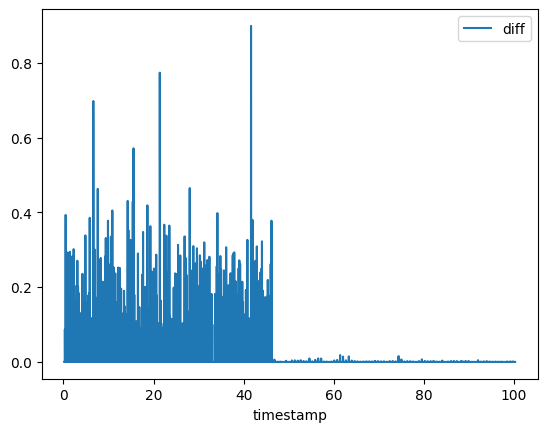

In [6]:
df.plot(x='timestamp', y='diff', kind='line')

In [7]:
def plotDiffOverTime(scan):
    scan_filtered = list(filter(lambda x: x['label'] == 'Beacon Location Update', scan))
    timestamps = np.full(len(scan_filtered), np.nan)
    xs = np.full(len(scan_filtered), np.nan)
    ys = np.full(len(scan_filtered), np.nan)
    zs = np.full(len(scan_filtered), np.nan)
    for i, entry in enumerate(scan_filtered):
        timestamps[i] = entry['timestamp']
        if 'position' not in entry['content']:
            continue
        position = entry['content']['position']
        xs[i] = position[0]
        ys[i] = position[1]
        zs[i] = position[2]

    timestamps = timestamps - min(timestamps)

    df = pd.DataFrame({'timestamp': timestamps, 'x': xs, 'y': ys, 'z': zs})
    df = df.dropna()
    df['diff'] = np.sqrt((df['x'] - df['x'].shift(1))**2 + (df['y'] - df['y'].shift(1))**2 + (df['z'] - df['z'].shift(1))**2)
    df = df[['timestamp', 'diff']]
    df.plot(x='timestamp', y='diff', kind='line')

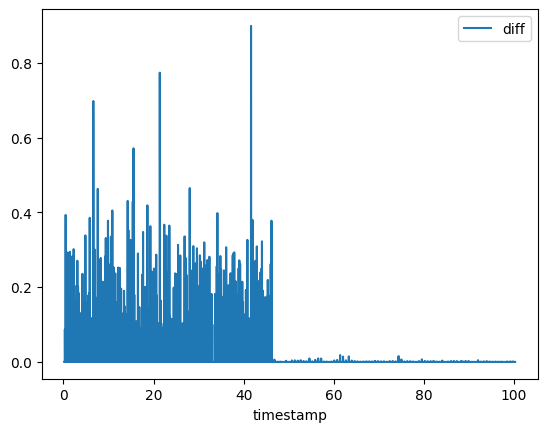

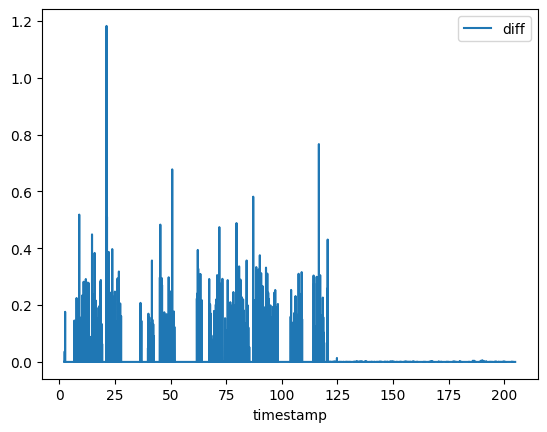

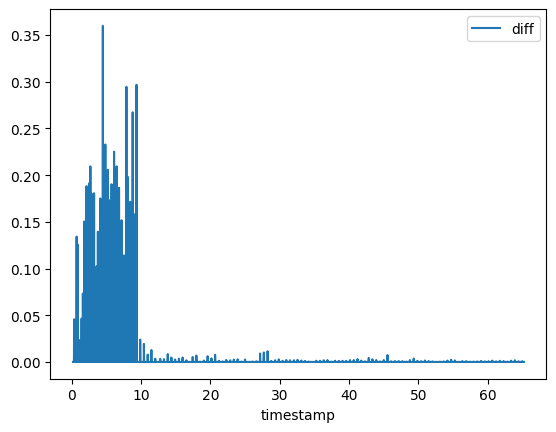

In [8]:
for scan in scans:
    plotDiffOverTime(scan)

In [9]:
treshold = 0.1 # meters
confirming_delay = 15 # seconds

def findStopTimestamp(scan):
    scan_filtered = list(filter(lambda x: x['label'] == 'Beacon Location Update', scan))

    first_consecutive_treshold_passed_timestamp = None
    last_entry_position = None
    
    for entry in scan_filtered:
        timestamp = entry['timestamp'] 
        if 'position' not in entry['content']:
            continue
        position = np.array(entry['content']['position'])
        if last_entry_position is not None:
            distance = np.linalg.norm(last_entry_position-position)
            if distance > treshold:
                first_consecutive_treshold_passed_timestamp = None
            else:
                if first_consecutive_treshold_passed_timestamp is None:
                    first_consecutive_treshold_passed_timestamp = timestamp
                elif timestamp - first_consecutive_treshold_passed_timestamp > confirming_delay:
                    return timestamp
        last_entry_position = position
    return None

In [10]:
for scan in scans:
    print(findStopTimestamp(scan))

1741771174.972003
1741770963.105896
1741771288.938641


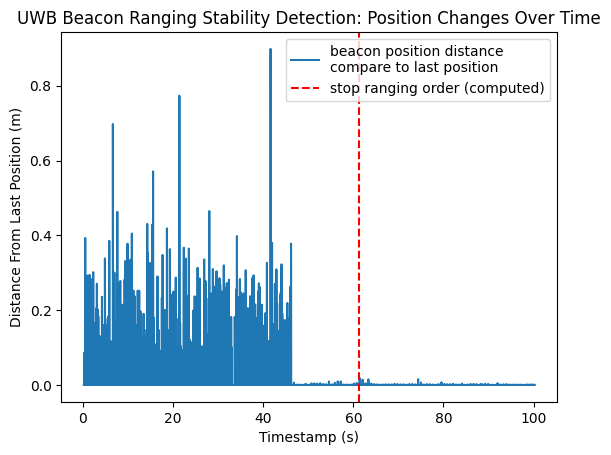

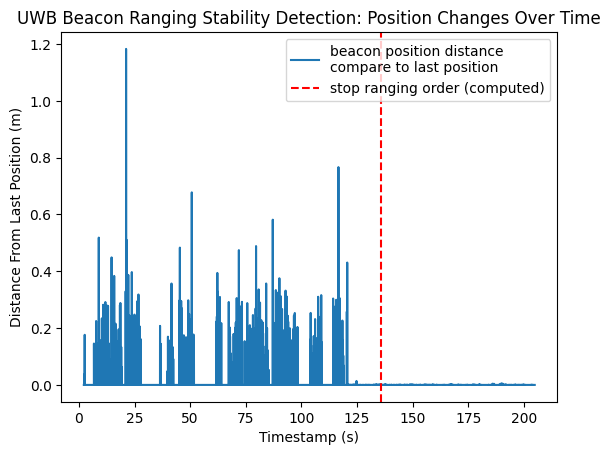

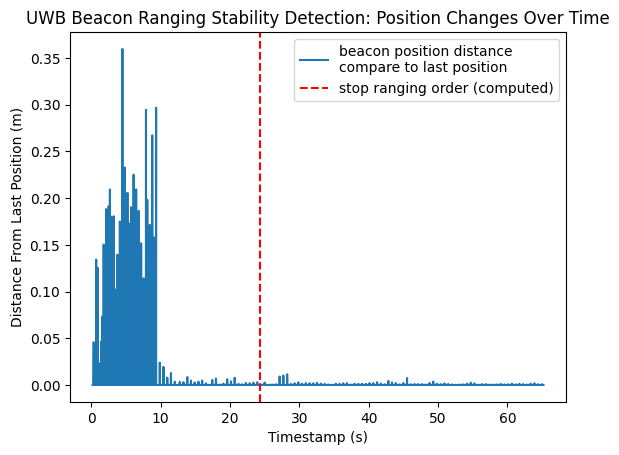

In [11]:
import matplotlib.pyplot as plt
def plotDiffOverTimeWithStopLine(scan):
    stopTimestamp = findStopTimestamp(scan)
    scan_filtered = list(filter(lambda x: x['label'] == 'Beacon Location Update', scan))
    
    timestamps = np.full(len(scan_filtered), np.nan)
    xs = np.full(len(scan_filtered), np.nan)
    ys = np.full(len(scan_filtered), np.nan)
    zs = np.full(len(scan_filtered), np.nan)
    for i, entry in enumerate(scan_filtered):
        timestamps[i] = entry['timestamp']
        if 'position' not in entry['content']:
            continue
        position = entry['content']['position']
        xs[i] = position[0]
        ys[i] = position[1]
        zs[i] = position[2]

    df = pd.DataFrame({'timestamp': timestamps - min(timestamps), 'x': xs, 'y': ys, 'z': zs})
    df = df.dropna()
    df['diff'] = np.sqrt((df['x'] - df['x'].shift(1))**2 + (df['y'] - df['y'].shift(1))**2 + (df['z'] - df['z'].shift(1))**2)
    df = df[['timestamp', 'diff']]
    
    plt.plot(df['timestamp'], df['diff'], label='beacon position distance \ncompare to last position')

    if stopTimestamp is not None:
        timestamp = stopTimestamp - min(timestamps)
        plt.axvline(x=timestamp, color='r', linestyle='--', label='stop ranging order (computed)')

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Distance From Last Position (m)')
    plt.title('UWB Beacon Ranging Stability Detection: Position Changes Over Time')
    plt.legend()
    plt.show()

for scan in scans:
    plotDiffOverTimeWithStopLine(scan)